# FAH GPU performance analysis example

**DISCLAIMER: the GPU benchmark data in this repo is experimental and not final. For now, the code and data presented here is intended as an example of parsing performance data from fah-core logs, and of the types of analysis that might be useful to automate intelligent assignment of work units to specific devices.**

Here we analyze performance data (`ns_per_day`) parsed from log files created by `fah-core` for the project `PROJ17101`. This project is intended to be a benchmark suite and contains 15 runs representative of the range of workloads run on FAH today.

In [1]:
import glob
import os
import altair as alt
import numpy as np
import pandas as pd
import seaborn as sns
from fah_log_parser import ParseError, parse, science_log
from fah_log_parser.util.pandas import parse_project_logs

## Parsing a single `science.log` file

In [2]:
log = parse(science_log, "../data/PROJ17102/RUN0/CLONE0/results0/science.log")

In [3]:
log.core_header.platform

'linux2 4.19.76-linuxkit'

In [4]:
platform, device = log.get_active_device()

In [5]:
platform

PlatformInfo(profile='FULL_PROFILE', version='OpenCL 1.2 CUDA 11.0.228', name='NVIDIA CUDA', vendor='NVIDIA Corporation')

In [6]:
device

Device(name='GeForce GTX 750 Ti', vendor='NVIDIA Corporation', version='OpenCL 1.2 CUDA', driver_version='450.66')

In [7]:
log.core_log.average_perf_ns_day

174.551

## Parsing all logs in a project

In [8]:
if os.path.exists("checkpoint"):
    data = pd.read_feather("checkpoint")
else:
    data = parse_project_logs("../data/PROJ17101/", sample=10000)
    data.reset_index.to_feather("checkpoint")
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   run                    5994 non-null   int64  
 1   clone                  5994 non-null   int64  
 2   gen                    5994 non-null   int64  
 3   os                     5994 non-null   object 
 4   platform_name          5994 non-null   object 
 5   platform_vendor        5994 non-null   object 
 6   platform_version       5994 non-null   object 
 7   device_name            5994 non-null   object 
 8   device_vendor          5994 non-null   object 
 9   device_version         5994 non-null   object 
 10  device_driver_version  14 non-null     object 
 11  cuda_enabled           5994 non-null   bool   
 12  perf_ns_per_day        5903 non-null   float64
dtypes: bool(1), float64(1), int64(3), object(8)
memory usage: 567.9+ KB


In [9]:
df = (data
 .set_index(['run', 'clone', 'gen', 'device_name'])
 ['perf_ns_per_day']
 .groupby('device_name').filter(lambda x: len(x) > 10)
 .groupby('run').transform(lambda x: (x - x.mean()) / x.std()).rename('z_score_by_run')
 .groupby('device_name').mean()
).reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("z_score_by_run:Q", aggregate='mean'),
    y=alt.Y("device_name:N", sort='-x')
)

alt.Chart(...)

In [10]:
df = (data
 .set_index(['run', 'clone', 'gen', 'device_name'])
 ['perf_ns_per_day']
 .groupby(['run', 'device_name']).filter(lambda x: len(x) > 10)
 .groupby('device_name').filter(lambda x: len(x.groupby('run')) == 15)
 .groupby(['run', 'device_name']).mean()
 .rename('mean_ns_per_day')
).reset_index()

alt.Chart(df).mark_point(filled=True).encode(
    x=alt.X('mean_ns_per_day:Q', scale=alt.Scale(type='log')),
    y=alt.Y('device_name:O', sort='-x'),
    color='run:N',
)

alt.Chart(...)

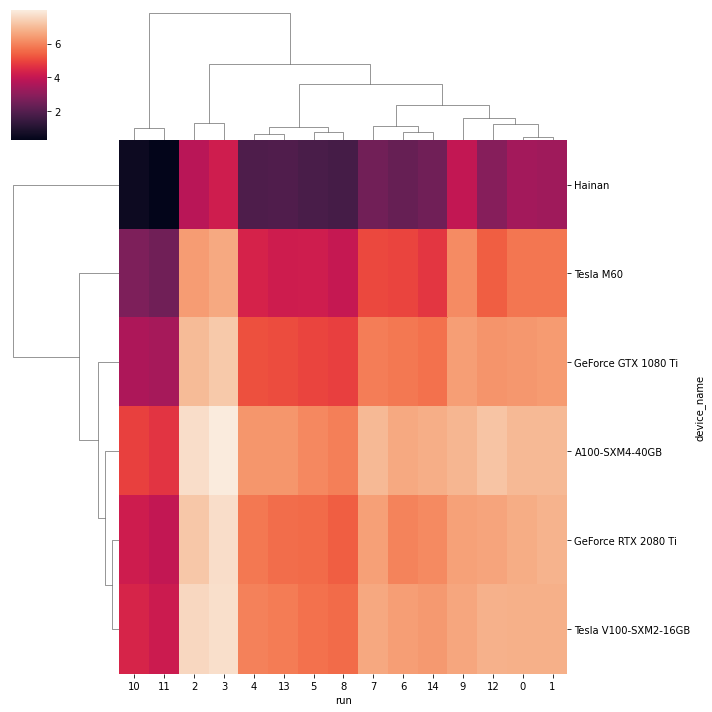

In [11]:
sns.clustermap(
    data
    .groupby(['run', 'device_name']).filter(lambda x: len(x) > 10)
    .groupby('device_name').filter(lambda x: len(x.groupby('run')) == 15)
    .groupby(['run', 'device_name'])
    ['perf_ns_per_day']
    .mean()
    .pipe(lambda x: np.log(x))
    .unstack('run'))